# Generation of training data for Machine Learning flow rules

Machine Learning (ML) algorithms provide a great flexibility to describe aribitrary mathematical functions. At the same time they offer the possibility to handle large data sets and multi-dimensional features as input. Hence, using ML algorithms as constitutive rules for plastic material behavior offers the possibility to explicitly take into account microstructural information of the material in the constitutive modeling. 

The present example is using Support Vector Classification (SVC) as yield function. The SVC algorithm is trained by using full tensorial stresses as input data, including normal and shear components, and the information whether a given stress state leads to purely elastic or rather to elastic-plastic deformation of the material as result data. In this way, a ML yield function is obtained, which can determine whether a given stress state lies inside or outside of the elastic regime of the material. Furthermore, the yield locus, i.e., the hyperplane in stress space on which plastic deformation occurs, can be reconstructed from the SVC, and the gradient on this yield locus can be conveniently calculated. Therefore, the standard formulations of continuum plasticity, as the return mapping algorithm, can be applied in Finite Element Analysis (FEA) in the usual way. Thus, it is demonstrated that the new ML yield function can replace conventional FEA yield functions. In a next step, microstructural information will be considered directly as feature. Machine learning algorithms have been adopted from the scikit-learn platform (https://scikit-learn.org/stable/). 

This package demonstrates how suited data sets for the training of ML flow rules in FEA can be generated. These data sets represent the ground truth that is approximated by the trained ML model. in form of a simple example with data synthetically produced from standard flow rules, like isotropic J2 (von Mises) and Hill-type anisotropic plasticity. It uses the pyLabFEM module. This notebook uses the matplotlib (https://matplotlib.org/) library for the visualization of results and NumPy (http://www.numpy.org) for mathematical operations with arrays.

The scientific background of this work is desribed in mode detail in the article by A. Hartmaier "Data-Oriented Constitutive Modeling of Plasticity in Metals" *Materials* 2020, 13(7), 1600. This open access article is available <a rel="preprint" href="https://www.mdpi.com/1996-1944/13/7/1600#">here</a>.

Author: Alexander Hartmaier, ICAMS, Ruhr-Universtität Bochum, Germany, December 2021

This work is licensed under a Creative 
Commons Attribution-NonCommercial-ShareAlike 4.0 International License
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">(CC-BY-NC-SA)</a>
 <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
<img alt="Creative Commons License" style="border-width:0;max-heigt:9px;height:100%;" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>

The pyLabFEA package comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under the conditions of
the GNU General Public License <a href="http://www.fsf.org/licensing/licenses/gpl.html">(GPLv3)</a> 


## Theoretical background
The notation of the Voigt Stress tensor is
\begin{equation} \pmb \sigma = \left( \sigma_1, \sigma_2, \sigma_3, \sigma_4, \sigma_5, \sigma_6 \right) \end{equation}


The yield function of a material is defined as 
\begin{equation} f(\pmb \sigma) = \sigma_{eq}(\pmb \sigma) -\sigma_y  \end{equation}
where plastic deformation sets in at $f=0$, i.e. when the the equivalent stress $\sigma_{eq}$ equals the yield strength $\sigma_y$ of the material. The equivalent stress used here follows the definition of Hill for anisotropic materials.

\begin{equation}
\begin{aligned}
\sigma_{eq}(\pmb \sigma) = 
                      \frac{1}{\sqrt{2}} \Big[  \Big. & H_1 \left(\sigma_1-\sigma_2\right)^2 + H_2\left(\sigma_2-\sigma_3\right)^2 + 
                      H_3\left(\sigma_3-\sigma_1\right)^2  \\
                    & \Big.  {} + 6H_4\sigma_4{}^2 + 6H_5\sigma_5{}^2 + 6H_6\sigma_6{}^2 \Big]^{1/2}
\end{aligned}
\end{equation}

In this yield function, the anisotropy of the material's flow behavior is described in a Hill-like approach, where the anisotropic flow behavior of the material is controlled by the parameters $H_1$, ..., $H_6$. Note that these paramaters correspond to the parameters used in the conventional Hill yield criterion

\begin{equation}
F\left(\sigma_2 -\sigma_3 \right)^2 + G\left(\sigma_3 -\sigma_1 \right)^2 + H\left(\sigma_1 -\sigma_2 \right)^2 +
2L\sigma_4^2 + 2M\sigma_5^2 + 2N\sigma_6^2 = 1
\end{equation}

when $H=H_1\sigma_y^2, F=H_2\sigma_y^2, G=H_3\sigma_y^2, L=3H_4\sigma_y^2, M=3H_5\sigma_y^2, N=3H_6\sigma_y^2$. The special case $H_1 = H_2 =...= H_6 = 1$ describes isotropic plastic behavior, where the equivalent stress defined here is identical to the von Mises (J2) equivalent stress. 

The gradient of the yield function with respect to the stress components is needed for calculating the plastic strain increments in the return mapping algorithm of continuum plasticity, and can be evaluated analytically as
\begin{eqnarray}
\frac{\partial f}{\partial \sigma_1} &=& \frac{\partial \sigma_{eq}}{\partial \sigma_1} =
\frac{\left(H_1+H_3\right) \sigma_1 - H_1 \sigma_2 - H_3 \sigma_3}{2\sigma_{eq}}  \\
\frac{\partial f}{\partial \sigma_2} &=& \frac{\partial \sigma_{eq}}{\partial \sigma_2} =
\frac{\left(H_2+H_1\right) \sigma_2 - H_1 \sigma_1 - H_2 \sigma_3}{2\sigma_{eq}}  \\
\frac{\partial f}{\partial \sigma_3} &=& \frac{\partial \sigma_{eq}}{\partial \sigma_3} =
\frac{\left(H_3+H_2\right) \sigma_3 - H_3 \sigma_1 - H_2 \sigma_2}{2\sigma_{eq}}  \\
\frac{\partial f}{\partial \sigma_4} &=& \frac{\partial \sigma_{eq}}{\partial \sigma_4} =
3 H_4 \frac{\sigma_4}{\sigma_{eq}} \\
\frac{\partial f}{\partial \sigma_5} &=& \frac{\partial \sigma_{eq}}{\partial \sigma_5} =
3 H_5 \frac{\sigma_5}{\sigma_{eq}} \\
\frac{\partial f}{\partial \sigma_6} &=& \frac{\partial \sigma_{eq}}{\partial \sigma_6} =
3 H_6 \frac{\sigma_6}{\sigma_{eq}} \\
\end{eqnarray}

Note that in the case of isotropic plasticity, i.e. $H_1=H_2=...=H_6=1$, the gradient takes the simple form
\begin{equation}
\frac{\partial f}{\partial \pmb \sigma} = \frac{3}{2} \frac{\pmb \sigma^\mathrm{dev}}{\sigma_{eq}} \hspace{2em} ,
\end{equation}
where $\pmb \sigma^\mathrm{dev}=\left( \sigma_1 -p, \sigma_2-p, \sigma_3-p, \sigma_4, \sigma_5, \sigma_6 \right)$ is
the deviatoric stress  and $p = \mbox{Tr}(\sigma)/3$ is the hydrostatic stress.


## Material definition
In the following, the Python class `Material` is invoked to be used as a material card in FEA, demonstrating the application of standard flow rules and machine learning (ML) flow rules. This class `Material` contains the attributes and methods to defining the elastic and plastic material behavior and to evaluate the materials constitutive behavior. Furthermore, all necessary subroutines for plotting the results are defined.
Two identical materials are defined,`mat_h` will be used to apply the standard Hill-like flow rules in FEA and to generate synthetical data that is used to train a ML flow rule in `mat_ml`. Consequently,`mat_h` and `mat_ml` should reveal identical properties, which is verified in simple FEA demonstrations for 2D plane stress cases. Here, we consider ideal plasticity, i.e. no work hardening, and no dependence on the hydrostatic stress.
        

pyLabFEA version 4.1
---------------------------------------------------------
J2 yield stress under uniax-x loading: 58.554 MPa
---------------------------------------------------------
J2 yield stress under uniax-y loading: 54.772 MPa
---------------------------------------------------------
J2 yield stress under equibiax loading: 65.079 MPa
---------------------------------------------------------
J2 yield stress under shear loading: 54.396 MPa
---------------------------------------------------------


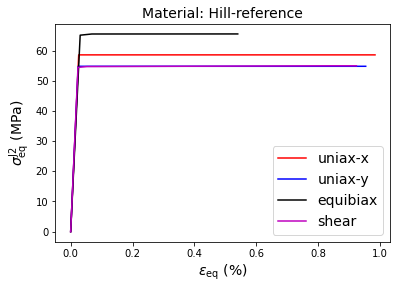

In [1]:
import pylabfea as FE
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
print('pyLabFEA version', FE.__version__)

#define Hill model as reference material
E=200000.
nu=0.3
sy=60.
hill = [1.4, 1., 0.7, 1.3, .8, 1.]
mat_h = FE.Material(name='Hill-reference', num=1)
mat_h.elasticity(E=E, nu=nu)
mat_h.plasticity(sy=sy, hill=hill, sdim=6)
mat_h.calc_properties(eps=0.01, sigeps=True)
mat_h.plot_stress_strain()

### Create a set of yield stresses in the stress space that serve as ground truth for the training of the ML yield function 

This is accomplished by first creating unit stresses that are uniformaly distributed in the full stress space plus some more unit stresses lying uniformly in the principal stress space, which are necessary to obtain a good training result. Then each unit stress is increased proportionally until the yield function for this stress tensor is zero, plastic yielding starts for this specific stress tensor. The full set of stress tensors at the onset of plastic yielding represents the yield function in a data-oriented way and, thus, represents the groung truth for the training of the ML yield function.

In [2]:
def find_yloc(x, sig, mat):
    # Expand unit stresses 'sig' by factor 'x' and calculate yield function
    return mat.calc_seq(sig*x[:,None]) - mat.sy

# create set of unit stresses and assess yield stresses
sunit = FE.load_cases(number_3d=100, number_6d=200)
N = len(sunit)
# calculate yield stresses from unit stresses
x1 = fsolve(find_yloc, np.ones(N) * mat_h.sy, args=(sunit, mat_h), xtol=1.e-5)
sig = sunit * x1[:,None]

#calculate reference yield stresses for uniaxial, equi-biaxial and pure shear load cases
sunit =np.zeros((6,6))
sunit[0,0] = 1.
sunit[1,1] = 1.
sunit[2,2] = 1.
sunit[3,0] = 1.
sunit[3,1] = 1.
sunit[4,0] =  1./np.sqrt(3.)
sunit[4,1] = -1./np.sqrt(3.)
sunit[5,3] = 1.
x1 = fsolve(find_yloc, np.ones(6) * mat_h.sy, args=(sunit, mat_h), xtol=1.e-5)
sy_ref = sunit * x1[:, None]
seq_ref = FE.seq_J2(sy_ref)
print('Reference yield stresses (MPa):')
print('Uniaxial x:',seq_ref[0])
print('Uniaxial y:',seq_ref[1])
print('Uniaxial z:',seq_ref[2])
print('Equibiaxial x-y:',seq_ref[3])
print('Pure shear x-y:',seq_ref[4])
print('Simple shear x-y:',seq_ref[5])


Reference yield stresses (MPa):
Uniaxial x: 58.554004376912
Uniaxial y: 54.772255750516614
Uniaxial z: 65.07913734559685
Equibiaxial x-y: 65.07913734559685
Pure shear x-y: 54.39580966939496
Simple shear x-y: 52.62348115842175


### Train ML yield function

Based on the data set of stress tensors at the onset of plastic yielding, the ML yield function based on the Support Vector Classification (SVC) is trained. For the classification, all stress values lying inside the yield locus, yield a negative value of the yield function, stress tensor lying on the yield locus will produce a yield function with a value of zero. Stresses that exceed the yield criterion will produce a positive value of the yield function. Hence, it is seen, that the sign of the yield function, corresponds to the sign of the analytical yield function defined above in the section on the theoretical background. In this way, the zeros of the ML yield function and the analyitcal yield function, describe the same yield locus, as manifold in the stress space. Hence, also the gradients to the yield function will be represented truly, whereas the absolute values of ML yield function and analytical yield function might differ. 

Note that the support vectors lie in close proximity of the yield locus, which is represented as ellipsis on the two-dimensional deviatoric principal stress space ($\pi$-plane).


---------------------------

SVM classification training
---------------------------

Training data created from 6-dimensional yield stresses with 300 load cases.
Using (16200, 6) full Voigt yield stresses for training.
SVC(C=15.0, gamma=2.5)
Training set score: 100.0 %
ML material with 340 support vectors, C=15.0, gamma=2.5, stress dimensions=6


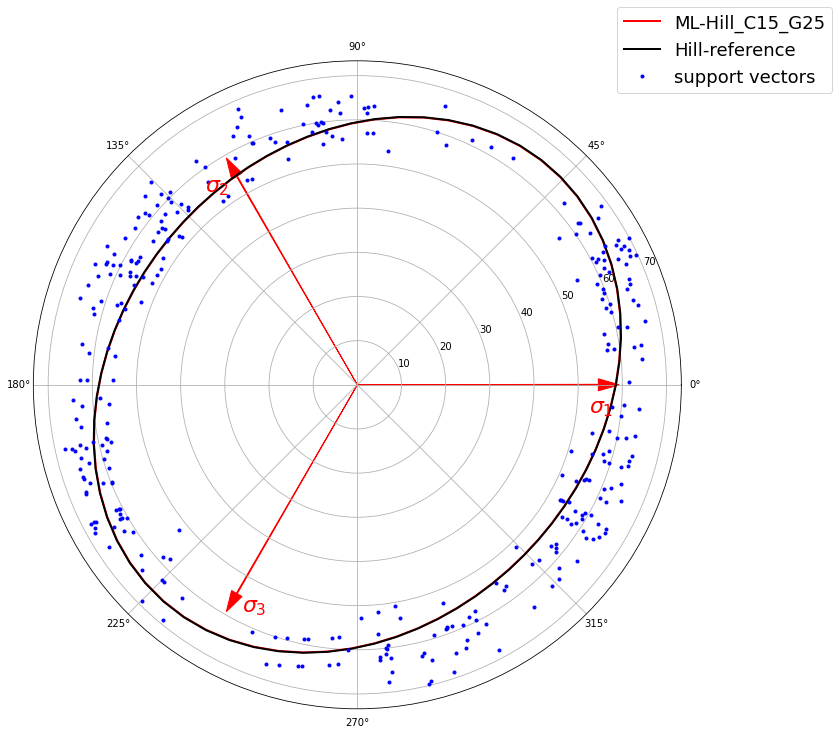

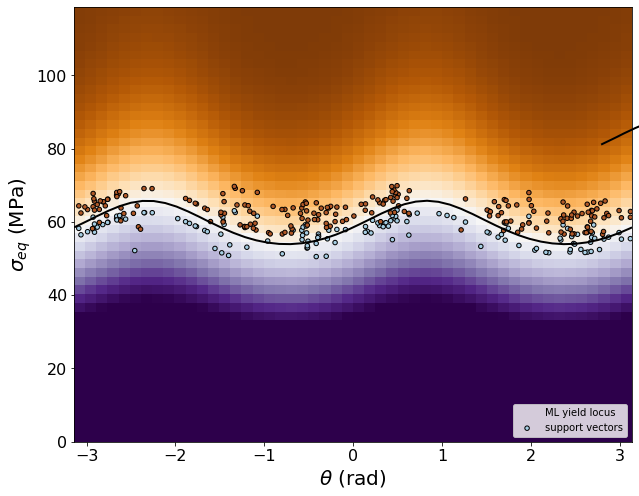

In [4]:
# define material as basis for ML flow rule
C=15.
gamma=2.5
name = 'ML-Hill_C{}_G{}'.format(int(C),int(gamma*10))
mat_mlh = FE.Material(name, num=2)  # define ML material
mat_mlh.elasticity(E=E, nu=nu)  # elastic parameters must be provided
mat_mlh.train_SVC(C=C, gamma=gamma, sdata=sig) # train ML flowrule from data obtained from reference material

#analyze support vectors to plot them in stress space
sv = mat_mlh.svm_yf.support_vectors_ * mat_mlh.scale_seq
Nsv = len(sv)
sc = FE.s_cyl(sv)
yf = mat_mlh.calc_yf(sv, pred=True)
print("ML material with {} support vectors, C={}, gamma={}, stress dimensions={}"\
    .format(Nsv,mat_mlh.C_yf,mat_mlh.gam_yf,mat_mlh.sdim))
mat_mlh.polar_plot_yl(data=sc, dname='support vectors', cmat=[mat_h], arrow=True)
plt.show()

#create plot of trained yield function in cylindrical coordinates for the 2D deviatoric principal stress space (pi plane)
ngrid = 50
xx, yy = np.meshgrid(np.linspace(-1, 1, ngrid),np.linspace(0, 2, ngrid))
yy *= mat_mlh.scale_seq
xx *= np.pi
hh = np.c_[yy.ravel(),xx.ravel()]
Z = mat_mlh.calc_yf(FE.sp_cart(hh))  # value of yield function for every grid point
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
line = mat_mlh.plot_data(Z, ax, xx, yy, c='black')
pts  = ax.scatter(sc[:,1], sc[:,0], s=20, c=yf, cmap=plt.cm.Paired, edgecolors='k') # plot support vectors
ax.set_xlabel(r'$\theta$ (rad)', fontsize=20)
ax.set_ylabel(r'$\sigma_{eq}$ (MPa)', fontsize=20)
ax.set_ylim(0.,2.*mat_mlh.sy)
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)
ax.legend([line[0], pts], ['ML yield locus', 'support vectors'], loc='lower right')
plt.show()

Plots of trained SVM classification with support vectors in cylindrical coordinates on the $\pi$-plane
(space of principal deviatoric stresses). 

(top) Polar plot: Red arrows indicate the directions of the axes in the principal stress space.

(bottom) Plot in cylindrical coordinates: Orange colors represent positive values of the yield function, i.e. they indicate plastic yielding.
Purple colors represent negative values of the yield function, where the stress lies in the elastic regime.

Note that some support vectors appear to lie in the wrong region, which is, however, a consequence
of the projection of full (6D) stresses onto the (2D) $\pi$-plane.

## Analyze ML constitutive model

The quality of the training of the ML flow rule is verified by comparing the signs of the values of the analytical yield function and the ML yield function for random stresses in the vicinity of the yield locus.

Confusion matrix for the predicted and reference labels of the yield function.


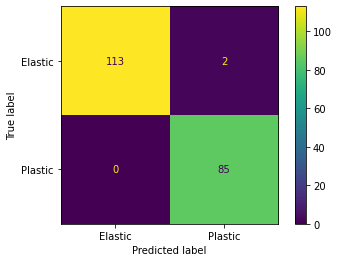

Mean Absolut Error is 4.6186043956016904
True Positives: 85
True Negatives: 113
False Positives: 2
False Negatives: 0
Precision: 0.9770114942528736
Accuracy: 0.99
Recall: 1.0
F1score: 0.9883720930232558
Calculating stress-strain curves based on ML flow rule.
---------------------------------------------------------
J2 yield stress under uniax-x loading: 58.491 MPa
---------------------------------------------------------
J2 yield stress under uniax-y loading: 54.713 MPa
---------------------------------------------------------
J2 yield stress under equibiax loading: 65.003 MPa
---------------------------------------------------------
J2 yield stress under shear loading: 54.337 MPa
---------------------------------------------------------


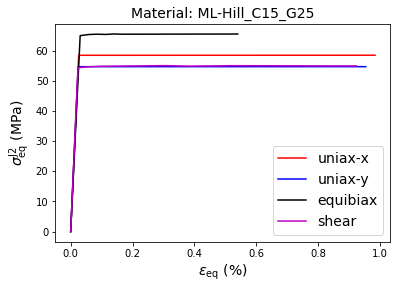

<Figure size 432x288 with 0 Axes>

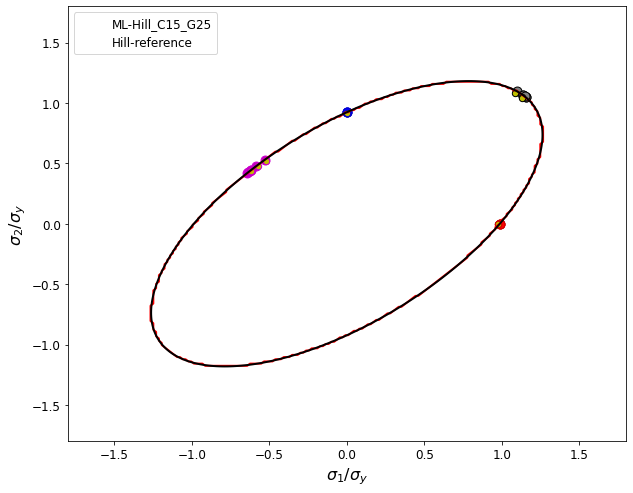

In [5]:
#calculate reference and analytical yield functions for random stresses
loc = mat_mlh.sy
scale = mat_mlh.sy*0.15
size = 200
X = np.random.normal(loc=loc, scale=scale, size=size)
sunittest = FE.load_cases(number_3d=0, number_6d=size)
sig_test = sunittest * X[:, None]
yf_ml = mat_mlh.calc_yf(sig_test)
yf_h = mat_h.calc_yf(sig_test)
print('Confusion matrix for the predicted and reference labels of the yield function.')
FE.training_score(yf_h,yf_ml)

# stress strain curves
print('Calculating stress-strain curves based on ML flow rule.')
mat_mlh.calc_properties(verb=False, eps=0.01, sigeps=True)
mat_mlh.plot_stress_strain()

# plot yield locus with flow stress states
s = 80
ax = mat_mlh.plot_yield_locus(xstart=-1.8, xend=1.8, ref_mat=mat_h, Nmesh=200)
stx = mat_mlh.sigeps['stx']['sig'][:, 0:2] / mat_mlh.sy
sty = mat_mlh.sigeps['sty']['sig'][:, 0:2] / mat_mlh.sy
et2 = mat_mlh.sigeps['et2']['sig'][:, 0:2] / mat_mlh.sy
ect = mat_mlh.sigeps['ect']['sig'][:, 0:2] / mat_mlh.sy
ax.scatter(stx[1:, 0], stx[1:, 1], s=s, c='r', edgecolors='#cc0000')
ax.scatter(sty[1:, 0], sty[1:, 1], s=s, c='b', edgecolors='#0000cc')
ax.scatter(et2[1:, 0], et2[1:, 1], s=s, c='#808080', edgecolors='k')
ax.scatter(ect[1:, 0], ect[1:, 1], s=s, c='m', edgecolors='#cc00cc')

#plot flow stresses from reference material
s = 40
stx = mat_h.sigeps['stx']['sig'][:, 0:2] / mat_h.sy
sty = mat_h.sigeps['sty']['sig'][:, 0:2] / mat_h.sy
et2 = mat_h.sigeps['et2']['sig'][:, 0:2] / mat_h.sy
ect = mat_h.sigeps['ect']['sig'][:, 0:2] / mat_h.sy
ax.scatter(stx[1:, 0], stx[1:, 1], s=s, c='y', edgecolors='#cc0000')
ax.scatter(sty[1:, 0], sty[1:, 1], s=s, c='y', edgecolors='#0000cc')
ax.scatter(et2[1:, 0], et2[1:, 1], s=s, c='y', edgecolors='k')
ax.scatter(ect[1:, 0], ect[1:, 1], s=s, c='y', edgecolors='#cc00cc')
plt.show()

Stress states and yield loci of the trained ML flow rule and the Hill-like reference material are plotted for four different load cases. The colored circles represent the flow stresses resulting from the ML yield function of the different load cases, and the small yellow circles show flow stresses from the analytical Hill-like yield function. 

### Apply trained ML flow rule in FEA

After the successful training of the ML yield function, it can be applied directly in FEA. Its gradients can be calculated directly from the coefficients and the support vectors resulting from the training process. The following code segment, demonstrates the application of the ML yield function in the pyLabFEA module. First, a model with two sections is generated, where section 1 is assigned to the reference material ``mat_h`` and section 2 is assigned to ``mat_mlh`` with the ML yield function. To generate a non-uniform deformation state,
a square-shaped soft elastic inclusion is placed in the center of the model.

=== Combined FEA with reference and ML material ===
Materials: ref=Hill-reference, ML=ML-Hill_C15_G25
Global strain:  [-0.0094  0.01    0.      0.      0.      0.    ]
Element strain (ref):  [-0.0104  0.0108  0.      0.      0.     -0.0005]
Element strain (ML):  [-0.0104  0.0108  0.      0.      0.      0.0005]
Global stress:  [ 1.7000e-02  5.7977e+01  3.3766e+01 -3.1000e-02  1.6000e-02 -8.0000e-03]
Element stress (ref):  [29.197 92.371 66.381  0.     0.    -0.404]
Element stress (ML):  [ 2.8784e+01  9.1971e+01  6.6084e+01 -7.1000e-02  3.6000e-02  3.5300e-01]
Global plastic strain:  [-8.31e-03  8.39e-03 -8.00e-05  0.00e+00 -0.00e+00  0.00e+00]
Plastic strain (ref):  [-0.01034  0.01049 -0.00015  0.       0.      -0.00047]
Plastic strain (ML):  [-0.01033  0.01048 -0.00015  0.      -0.       0.00051]
----------------------------
Material 1 (left block):   {'yield_fct': 'analytical', 'gradient': 'analytical, 6-parameter Hill, full stress', 'nsteps': 49, 'equiv': '6-parameter Hill, full Voi

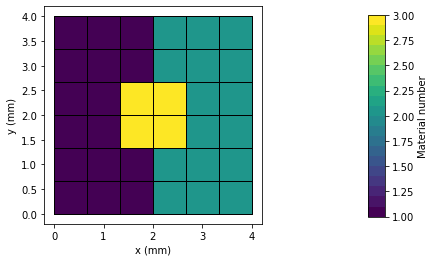

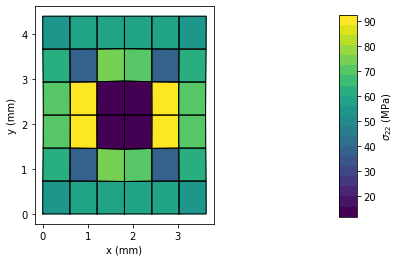

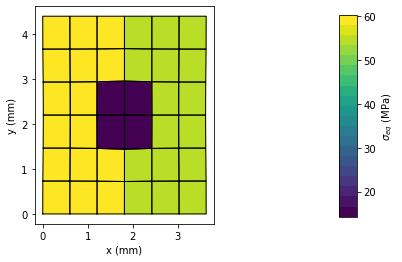

Note: Different definitions of SEQ for Hill and J2.


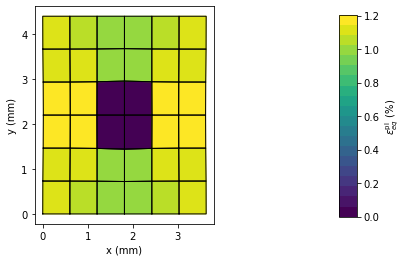

In [7]:
print('===================================================')
print('=== Combined FEA with reference and ML material ===')
print('===================================================')
# setup material definition for soft elastic square-shaped inclusion in
# elastic-plastic material (lhs: analytic Hill flow rule, rhs: ML flow rule)
# define soft elastic material for inclusion
mat_el = FE.Material(num=3)
mat_el.elasticity(E=1.e3, nu=0.27)
#define array for geometrical arrangement
NX = NY = 6
el = np.ones((NX, NY))  # field with material 1: reference
NX2 = int(NX/2)
el[NX2:NX,0:NY] = 2  # rhs for material 2: ML flow rule
NXi1 = int(NX/3)
NXi2 = 2*NXi1
NYi1 = int(NY/3)
NYi2 = 2*NYi1
el[NXi1:NXi2, NYi1:NYi2] = 3  # center material 3: elastic

# create FE model
fem=FE.Model(dim=2,planestress=False)
fem.geom(sect=3, LX=4., LY=4.) # define geometry with two sections
fem.assign([mat_h, mat_mlh, mat_el])  # define sections for reference, ML and elastic material
fem.bcbot(0., 'disp')  # fixed bottom layer
fem.bcleft(0., 'force')  # free lateral edges
fem.bcright(0., 'force')
fem.bctop(0.01*fem.leny, 'disp')  # apply displacement at top nodes (uniax y-stress)
fem.mesh(elmts=el, NX=NX, NY=NY)
# fix lateral displacements of corner node to prevent rigig body motion
hh = [no in fem.nobot for no in fem.noleft]
noc = np.nonzero(hh)[0]  # find corner node
fem.bcnode(noc, 0., 'disp', 'x')  # fix lateral displacement
fem.solve()
fem.calc_global()

ne1 = (NXi1-1)*NY + NYi1
ne2 = NXi2*NY + NYi1
print('Materials: ref={}, ML={}'.format(fem.element[ne1].Mat.name, fem.element[ne2].Mat.name))
print('Global strain: ', np.round(fem.glob['eps'],decimals=4))
print('Element strain (ref): ', np.round(fem.element[ne1].eps,decimals=4))
print('Element strain (ML): ', np.round(fem.element[ne2].eps,decimals=4))
print('Global stress: ', np.round(fem.glob['sig'],decimals=3))
print('Element stress (ref): ', np.round(fem.element[ne1].sig,decimals=3))
print('Element stress (ML): ', np.round(fem.element[ne2].sig,decimals=3))
print('Global plastic strain: ', np.round(fem.glob['epl'],decimals=5))
print('Plastic strain (ref): ', np.round(fem.element[ne1].epl,decimals=5))
print('Plastic strain (ML): ', np.round(fem.element[ne2].epl,decimals=5))
print('----------------------------')
print('Material 1 (left block):  ',mat_h.msg)
print('Material 2 (right block): ',mat_mlh.msg)
fem.plot('mat', shownodes=False, mag=0)
fem.plot('stress2',shownodes=False, mag=10)
fem.plot('seq', shownodes=False, mag=10)
print('Note: Different definitions of SEQ for Hill and J2.')
fem.plot('peeq', shownodes=False, mag=10)

Note that the element stresses in both materials are very similar (top figure). However, the different definitions of the Hill equivalent stress and the J2 equivalent stress produce a numerical difference in the plot of the equivalent stresses (middle figure). The resulting plastic strains in both sections are quite similar (bottom figure).

The second example demonstrates a simple shear load case, for the model composed of reference material with the anaytical Hill yield function and the ML material, which is trained based on the data geenrated from the reference material.

## Application to a Barlat-type reference material

In the following, the same workflow is applied to train a material with a Barlat-type yield function (Yld2004-18p model describing the anisotropic yield function with 18 parameters) that has been parametereized for a material with a strong Goss tecture, which reprensts a rather severe case of anisotropic yielding behavior.

In the first step, again the data set for the ground truth is produces, by identifying stress tensors suitably disctributed in the stress space for which the Barlat yield function is zero.

In [9]:
# define Barlat material for Goss texture (RVE data, combined data set)
# fitted to micromechanical data
E = 151220.
nu = 0.3
bp = [0.81766901, -0.36431565, 0.31238124, 0.84321164, -0.01812166, 0.8320893, 0.35952332,
      0.08127502, 1.29314957, 1.0956107, 0.90916744, 0.27655112, 1.090482, 1.18282173,
      -0.01897814, 0.90539357, 1.88256105, 0.0127306]
mat_GB = FE.Material(name='Yld2004-18p_from_Goss')
mat_GB.elasticity(E=E, nu=nu)
mat_GB.plasticity(sy=46.76, barlat=bp[0:18], barlat_exp=8)
# create set of unit stresses and assess yield stresses
sunit = FE.load_cases(number_3d=100, number_6d=200)
N = len(sunit)
# calculate yield stresses from unit stresses
x1 = fsolve(find_yloc, np.ones(N) * mat_GB.sy, args=(sunit, mat_GB), xtol=1.e-5)
sig = sunit * x1[:, None]

#calculate reference yield stresses for uniaxial, equi-biaxial and pure shear load cases
sunit =np.zeros((6,6))
sunit[0,0] = 1.
sunit[1,1] = 1.
sunit[2,2] = 1.
sunit[3,0] = 1.
sunit[3,1] = 1.
sunit[4,0] =  1./np.sqrt(3.)
sunit[4,1] = -1./np.sqrt(3.)
sunit[5,3] = 1.
x1 = fsolve(find_yloc, np.ones(6) * mat_GB.sy, args=(sunit, mat_GB), xtol=1.e-5)
sy_ref = sunit * x1[:, None]
seq_ref = FE.seq_J2(sy_ref)
print('Reference yield stresses (MPa):')
print('Uniaxial x:',seq_ref[0])
print('Uniaxial y:',seq_ref[1])
print('Uniaxial z:',seq_ref[2])
print('Equibiaxial x-y:',seq_ref[3])
print('Pure shear x-y:',seq_ref[4])
print('Simple shear x-y:',seq_ref[5])

Reference yield stresses (MPa):
Uniaxial x: 48.6885096974097
Uniaxial y: 44.111480238927484
Uniaxial z: 46.919201755980836
Equibiaxial x-y: 46.919201755980836
Pure shear x-y: 43.191102298319926
Simple shear x-y: 69.23435711957626


### Train ML flow rule based on data set of stress tensor at onset of yielding

Note that the number of training points and also their distribution in the stress space is identical to the canse of the Hill-type refernece material. Furthermore, also the hyperparameters for the training are identical to the case above.


---------------------------

SVM classification training
---------------------------

Training data created from 6-dimensional yield stresses with 300 load cases.
Using (16200, 6) full Voigt yield stresses for training.
SVC(C=15.0, gamma=2.5)
Training set score: 100.0 %
ML material with 235 support vectors, C=15.0, gamma=2.5, stress dimensions=6


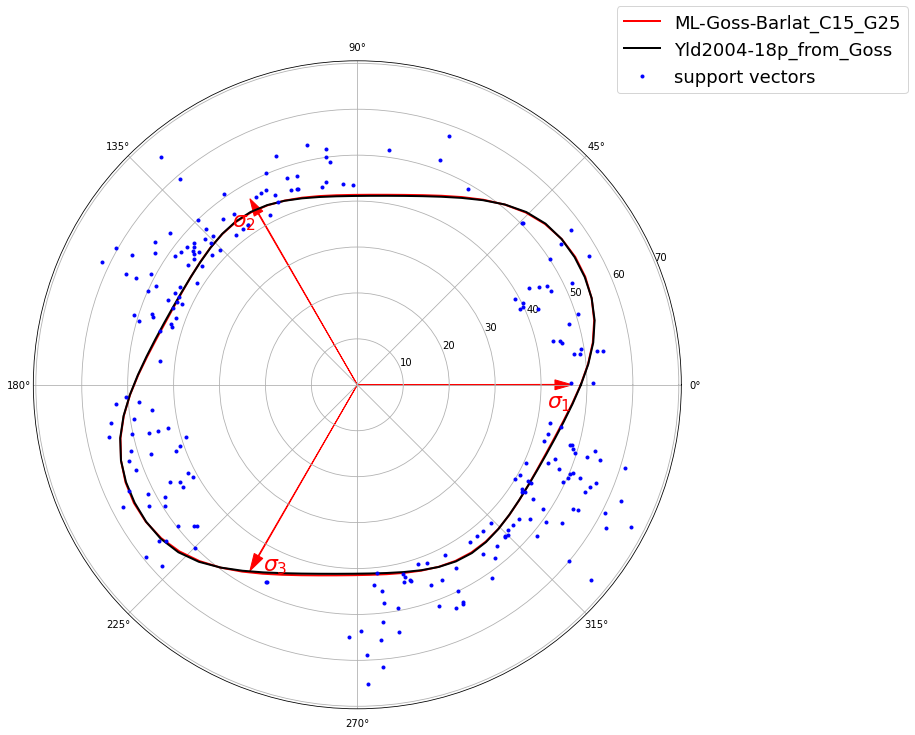

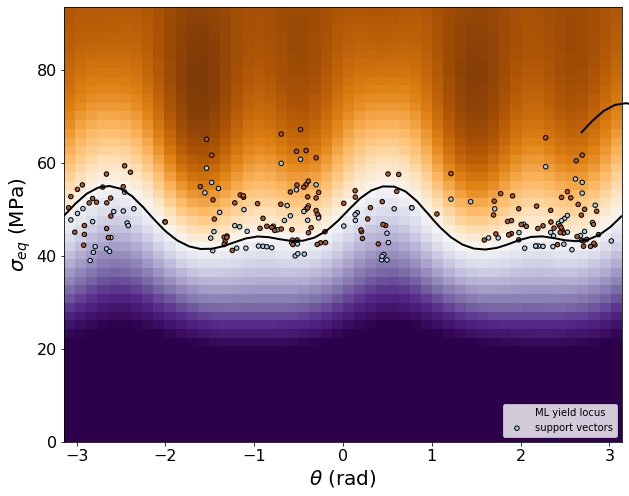

In [10]:
# define material as basis for ML flow rule
name = 'ML-Goss-Barlat_C{}_G{}'.format(int(C),int(gamma*10))
# convert yield stress data into a dataset suited for a material definition
mat_mlGB = FE.Material(name, num=4)  # initialize material 
mat_mlGB.elasticity(E=E, nu=nu) # elastic parameters must be provided
mat_mlGB.train_SVC(C=C, gamma=gamma, sdata=sig) # train ML flowrule from data obtained from reference material

#analyze support vectors to plot them in stress space
sv = mat_mlGB.svm_yf.support_vectors_ * mat_mlGB.scale_seq
Nsv = len(sv)
sc = FE.s_cyl(sv)
yf = mat_mlGB.calc_yf(sv, pred=True)
print("ML material with {} support vectors, C={}, gamma={}, stress dimensions={}"\
    .format(Nsv,mat_mlGB.C_yf,mat_mlGB.gam_yf,mat_mlGB.sdim))
mat_mlGB.polar_plot_yl(data=sc, dname='support vectors', cmat=[mat_GB], arrow=True)

#create plot of trained yield function in cylindrical stress space
#create mesh in stress space
ngrid = 50
xx, yy = np.meshgrid(np.linspace(-1, 1, ngrid),np.linspace(0, 2, ngrid))
yy *= mat_mlGB.scale_seq
xx *= np.pi
hh = np.c_[yy.ravel(),xx.ravel()]
Z = mat_mlGB.calc_yf(FE.sp_cart(hh))  # value of yield function for every grid point
fig, ax  = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
line = mat_mlGB.plot_data(Z, ax, xx, yy, c='black')
pts  = ax.scatter(sc[:,1], sc[:,0], s=20, c=yf, cmap=plt.cm.Paired, edgecolors='k') # plot support vectors
ax.set_xlabel(r'$\theta$ (rad)', fontsize=20)
ax.set_ylabel(r'$\sigma_{eq}$ (MPa)', fontsize=20)
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)
ax.set_ylim(0.,2.*mat_mlGB.sy)
ax.legend([line[0], pts], ['ML yield locus', 'support vectors'], loc='lower right')
plt.show()

Plots of trained SVM classification with support vectors in cylindrical coordinates on the $\pi$-plane
(space of principal deviatoric stresses). 

(top) Polar plot: Red arrows indicate the directions of the axes in the principal stress space.

(bottom) Plot in cylindrical coordinates: Orange colors represent positive values of the yield function, i.e. they indicate plastic yielding.
Purple colors represent negative values of the yield function, where the stress lies in the elastic regime.

Note that some support vectors appear to lie in the wrong region, which is, however, a consequence
of the projection of full (6D) stresses onto the (2D) $\pi$-plane.

### Analyze training result

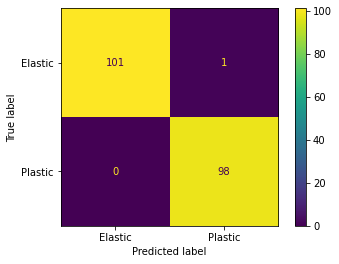

Mean Absolut Error is 3.9635553005819464
True Positives: 98
True Negatives: 101
False Positives: 1
False Negatives: 0
Precision: 0.98989898989899
Accuracy: 0.995
Recall: 1.0
F1score: 0.9949238578680203
Calculating stress-strain data ...
---------------------------------------------------------
J2 yield stress under uniax-x loading: 48.637 MPa
---------------------------------------------------------
J2 yield stress under uniax-y loading: 43.995 MPa
---------------------------------------------------------
J2 yield stress under equibiax loading: 47.11 MPa
---------------------------------------------------------
J2 yield stress under shear loading: 43.151 MPa
---------------------------------------------------------


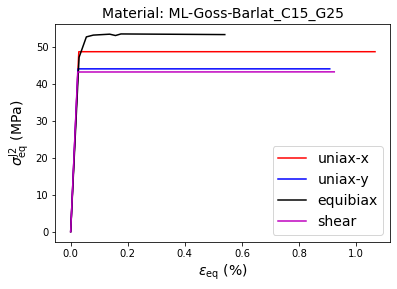

<Figure size 432x288 with 0 Axes>

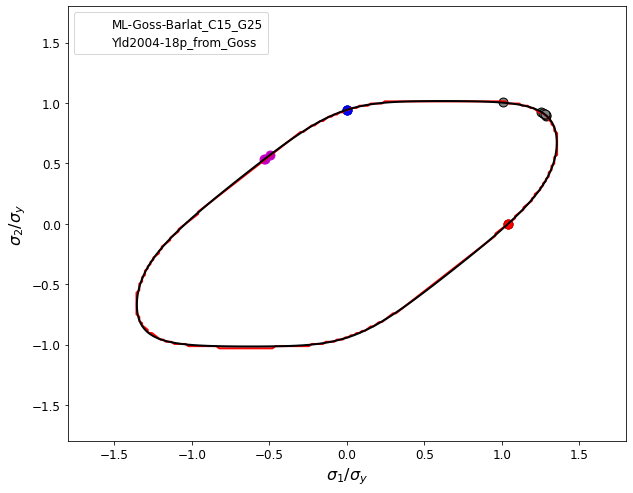

In [11]:
loc = mat_mlGB.sy
scale = mat_mlGB.sy*0.15
size = 200
X = np.random.normal(loc=loc, scale=scale, size=size)
sunittest = FE.load_cases(number_3d=0, number_6d=size)
sig_test = sunittest * X[:, None]
yf_ml = mat_mlGB.calc_yf(sig_test)
yf_GB = mat_GB.calc_yf(sig_test)
FE.training_score(yf_GB,yf_ml)

# stress strain curves
print('Calculating stress-strain data ...')
mat_mlGB.calc_properties(verb=False, eps=0.01, sigeps=True)
mat_mlGB.plot_stress_strain()

# plot yield locus with stress states
s = 80
ax = mat_mlGB.plot_yield_locus(xstart=-1.8, xend=1.8, ref_mat=mat_GB, Nmesh=200)
stx = mat_mlGB.sigeps['stx']['sig'][:, 0:2] / mat_mlGB.sy
sty = mat_mlGB.sigeps['sty']['sig'][:, 0:2] / mat_mlGB.sy
et2 = mat_mlGB.sigeps['et2']['sig'][:, 0:2] / mat_mlGB.sy
ect = mat_mlGB.sigeps['ect']['sig'][:, 0:2] / mat_mlGB.sy
ax.scatter(stx[1:, 0], stx[1:, 1], s=s, c='r', edgecolors='#cc0000')
ax.scatter(sty[1:, 0], sty[1:, 1], s=s, c='b', edgecolors='#0000cc')
ax.scatter(et2[1:, 0], et2[1:, 1], s=s, c='#808080', edgecolors='k')
ax.scatter(ect[1:, 0], ect[1:, 1], s=s, c='m', edgecolors='#cc00cc')
plt.show()


Stress states and yield loci of the trained ML flow rule according to the Barlat-type reference for a material with a pronounced Goss texture are plotted for four different load cases. The colored circles represent the flow stresses resulting from the ML yield function of the different load cases.

### FEA of model with elastic inclusion embedded in matrix with trained ML flow rule

=== FEA of inclusion with ML material ===


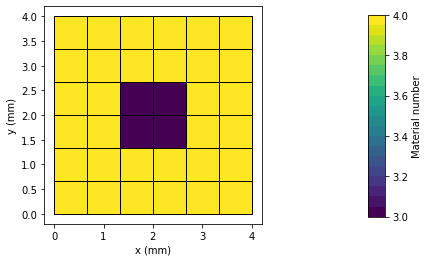

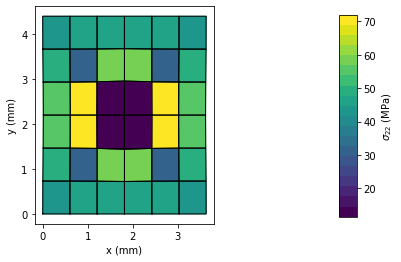

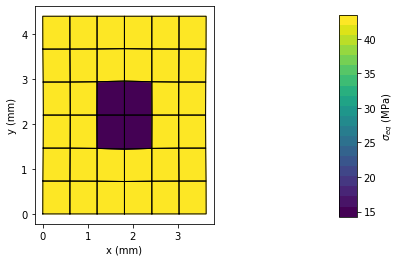

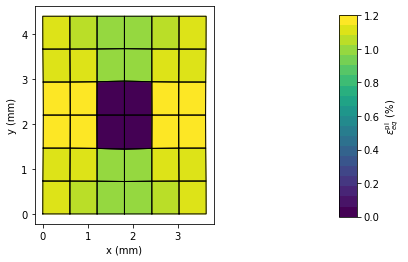

In [12]:
print('=========================================')
print('=== FEA of inclusion with ML material ===')
print('=========================================')
#define array for geometrical arrangement
NX = NY = 6
el = np.ones((NX, NY))  # field with material 1: reference
NXi1 = int(NX/3)
NXi2 = 2*NXi1
NYi1 = int(NY/3)
NYi2 = 2*NYi1
el[NXi1:NXi2, NYi1:NYi2] = 2  # center material 3: elastic

# create FE model
fem=FE.Model(dim=2,planestress=False)
fem.geom(sect=2, LX=4., LY=4.) # define geometry with two sections
fem.assign([mat_mlGB, mat_el])  # define sections for ML and elastic material
fem.bcbot(0., 'disp')  # fixed bottom layer
fem.bcleft(0., 'force')  # free lateral edges
fem.bcright(0., 'force')
fem.bctop(0.01*fem.leny, 'disp')  # apply displacement at top nodes (uniax y-stress)
fem.mesh(elmts=el, NX=NX, NY=NY)
# fix lateral displacements of corner node to prevent rigig body motion
hh = [no in fem.nobot for no in fem.noleft]
noc = np.nonzero(hh)[0]  # find corner node
fem.bcnode(noc, 0., 'disp', 'x')  # fix lateral displacement
fem.solve()
fem.calc_global()

fem.plot('mat', mag=0, shownodes=False)
fem.plot('stress2',mag=10, shownodes=False)
fem.plot('seq',mag=10, shownodes=False)
fem.plot('peeq',mag=10, shownodes=False)